In [5]:
import sys
import os

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [172]:
import Preprocessing.preprocessing as pp
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pylab
import math
import Preprocessing.image_processing as ip
import sklearn.metrics as metrics
from sklearn import preprocessing

Load in the data from a csv of pixel data, and a csv of labels

In [8]:
train_csv_x = '/Users/joelpersson/Documents/GitHub/CS229A/Data/train_images.csv'
train_csv_y = '/Users/joelpersson/Documents/GitHub//CS229A/Data/train_labels.csv'

X, Y = pp.load_XY(train_csv_x, train_csv_y)

Reshape the $Y$ vector (works better during the fitting)

In [57]:
Y = Y.reshape(-1)

Load the validation set

In [28]:
val_csv_x = '/Users/joelpersson/Documents/GitHub/CS229A/Data/val_images.csv'
val_csv_y = '/Users/joelpersson/Documents/GitHub//CS229A/Data/val_labels.csv'

X_val, Y_val = pp.load_XY(val_csv_x, val_csv_y)

### Train on 96x96 images

Fit a logistic regression to the data

In [19]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X, Y)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Predict on the training data to calculate the accuracy (not the final evaluation metric for models)

In [25]:
y_pred_train = clf.predict(X)

In [89]:
print("Accuracy on train set: ",1 - np.mean(np.abs(y_pred_train-Y.T)))

Accuracy on train set:  0.9236666666666666


Predict on the validation data set

In [29]:
y_pred_val = clf.predict(X_val)

In [90]:
print("Accuracy on validation set: ",1 - np.mean(np.abs(y_pred_val-Y_val.T)))

Accuracy on validation set:  0.5880000000000001


We can see that unregularized logistic regression performs poorly out of sample which is expected considering the input has $\approx 27,000$ features but we train it on $6,000$ examples which in turn creates problems of overfitting to the training data. Below we try different values of regularization and compare how that affects performance on both the training and the validation set.

In [175]:
reg = [np.exp(-i) for i in range(0, 30, 2)]
reg = sorted(reg)

In [186]:
def auroc_and_acc_vs_reg(reg, X, Y, X_val, Y_val):
    # function that returns auroc scores for different values of the regularization parameter
    auc_train = []
    auc_val = []
    acc_train = []
    acc_val = []
    
    for i, c_i in enumerate(reg):
        # fit a logistic regression using regularization c_i
        clf = LogisticRegression(solver='lbfgs', C=c_i).fit(X, Y)
        
        # evaluate accuracy on the training set
        y_pred_train = clf.predict(X)
        acc_train.append(1 - np.mean(np.abs(y_pred_train-Y.T)))
        
        # evaluate AUROC score on the training set
        proba_train = clf.predict_proba(X)[:,1]
        auc_train.append(metrics.roc_auc_score(Y, proba_train))
        
        # evaluate accuracy on the validation set
        y_pred_val = clf.predict(X_val)
        acc_val.append(1 - np.mean(np.abs(y_pred_val-Y_val.T)))

        # evaluate AUROC score on the validation set
        proba_val = clf.predict_proba(X_val)[:,1]
        auc_val.append(metrics.roc_auc_score(Y_val, proba_val))
        
    return auc_train, auc_val, acc_train, acc_val

In [187]:
auc_train, auc_val, acc_train, acc_val = auroc_and_acc_vs_reg(reg, X, Y, X_val, Y_val)

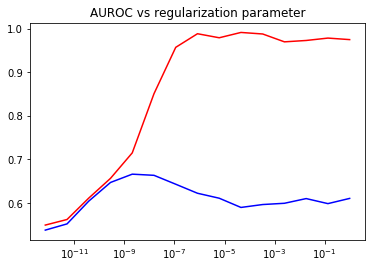

In [188]:
plt.title('AUROC vs regularization parameter')
plt.plot(np.array(reg), np.array(auc_train),'r')
plt.plot(np.array(reg), np.array(auc_val), 'b')
plt.xscale('log')
plt.show()

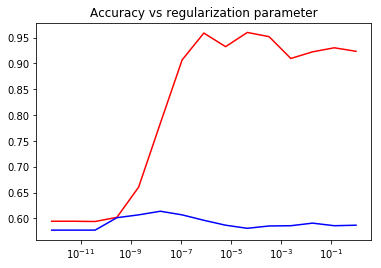

In [189]:
plt.title('Accuracy vs regularization parameter')
plt.plot(np.array(reg), np.array(acc_train),'r')
plt.plot(np.array(reg), np.array(acc_val), 'b')
plt.xscale('log')
plt.show()

In [190]:
print("Highest accuracy: ", np.max(acc_val))
print("Highest AUROC: ", np.max(auc_val))
print("The optimal regularization value is: ", reg[np.argmax(auc_val)])

Highest accuracy:  0.614
Highest AUROC:  0.6659186966879275
The optimal regularization value is:  2.061153622438558e-09


In [191]:
clf = LogisticRegression(random_state=0, solver='lbfgs', C=reg[np.argmax(auc_val)], multi_class='multinomial').fit(X, Y)
probs = clf.predict_proba(X_val)[:,1]

fpr, tpr, threshold = metrics.roc_curve(Y_val, probs)
roc_auc = metrics.auc(fpr, tpr)

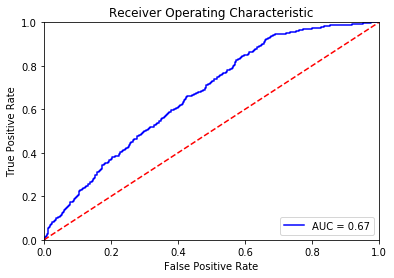

In [192]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Scale $96\times96$ features

In [178]:
X_scaled = preprocessing.scale(X)
X_val_scaled = preprocessing.scale(X_val)

In [193]:
auc_train_scaled, auc_val_scaled, acc_train_scaled, acc_val_scaled = auroc_and_acc_vs_reg(reg, X_scaled, Y, X_val_scaled, Y_val)

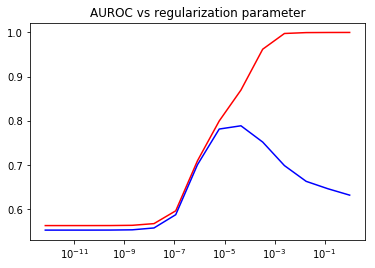

In [194]:
plt.title('AUROC vs regularization parameter')
plt.plot(np.array(reg), np.array(auc_train_scaled),'r')
plt.plot(np.array(reg), np.array(auc_val_scaled), 'b')
plt.xscale('log')
plt.show()

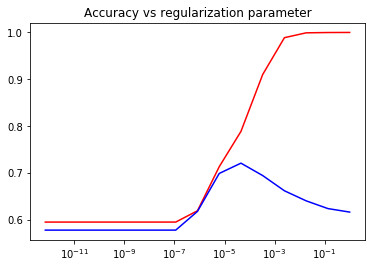

In [195]:
plt.title('Accuracy vs regularization parameter')
plt.plot(np.array(reg), np.array(acc_train_scaled),'r')
plt.plot(np.array(reg), np.array(acc_val_scaled), 'b')
plt.xscale('log')
plt.show()

In [199]:
print("Highest accuracy: ", np.max(acc_val_scaled))
print("Highest AUROC: ", np.max(auc_val_scaled))
print("The optimal regularization value is: ", reg[np.argmax(auc_val_scaled)])

Highest accuracy:  0.7204999999999999
Highest AUROC:  0.7888757396449704
The optimal regularization value is:  4.5399929762484854e-05


### Train on 32x32 images
Start by converting the $96\times96$ images to $32\times32$.

In [81]:
n = 32
X_32 = np.zeros((X.shape[0], n*n*3))
X_val_32 = np.zeros((X_val.shape[0], n*n*3))

In [85]:
for i in range(X.shape[0]):
    X_32[i] = ip.crop_center(X[i,:], (96,96,3), 32)

for j in range(X_val.shape[0]):
    X_val_32[j] = ip.crop_center(X_val[j,:], (96,96,3), 32)

Fit a logistic regression to the center $32\times32$ pixels.

In [77]:
clf_32 = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_32, Y)

In [79]:
y_pred_train_32 = clf_32.predict(X_32)

In [91]:
print("Accuracy on train set: ",1 - np.mean(np.abs(y_pred_train_32-Y.T)))

Accuracy on train set:  0.7391666666666667


Predict on the validation set.

In [87]:
y_pred_val_32 = clf_32.predict(X_val_32)

In [92]:
print("Accuracy on validation set: ",1 - np.mean(np.abs(y_pred_val_32-Y_val.T)))

Accuracy on validation set:  0.5954999999999999


Train the model for multiple values of the regularization parameter.

In [196]:
auc_train_32, auc_val_32, acc_train_32, acc_val_32 = auroc_and_acc_vs_reg(reg, X_32, Y, X_val_32, Y_val)

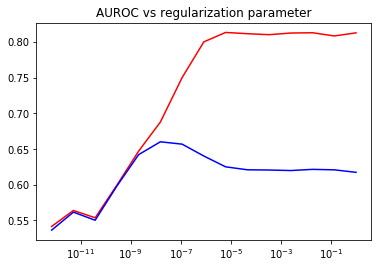

In [198]:
plt.title('AUROC vs regularization parameter')
plt.plot(np.array(reg), np.array(auc_train_32),'r')
plt.plot(np.array(reg), np.array(auc_val_32), 'b')
plt.xscale('log')
plt.show()

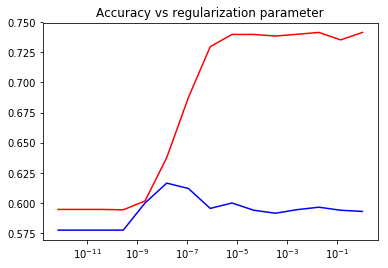

In [197]:
plt.title('Accuracy vs regularization parameter')
plt.plot(np.array(reg), np.array(acc_train_32),'r')
plt.plot(np.array(reg), np.array(acc_val_32), 'b')
plt.xscale('log')
plt.show()

In [200]:
print("Highest accuracy: ", np.max(acc_val_32))
print("Highest AUROC: ", np.max(auc_val_32))
print("The optimal regularization value is: ", reg[np.argmax(auc_val_32)])

Highest accuracy:  0.6165
Highest AUROC:  0.6599902661441124
The optimal regularization value is:  1.522997974471263e-08


In [126]:
clf_32 = LogisticRegression(random_state=0, solver='lbfgs', C=reg[np.argmax(auc_val_32)], multi_class='multinomial').fit(X_32, Y)
probs_32 = clf_32.predict_proba(X_val_32)[:,1]

fpr_32, tpr_32, threshold_32 = metrics.roc_curve(Y_val, probs_32)
roc_auc_32 = metrics.auc(fpr_32, tpr_32)

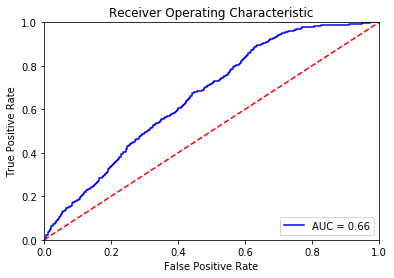

In [127]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_32, tpr_32, 'b', label = 'AUC = %0.2f' % roc_auc_32)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Scale $32\times32$ features

In [201]:
X_32_scaled = preprocessing.scale(X_32)
X_val_32_scaled = preprocessing.scale(X_val_32)

In [202]:
auc_train_32_scaled, auc_val_32_scaled, acc_train_32_scaled, acc_val_32_scaled = auroc_and_acc_vs_reg(reg, X_32_scaled, Y, X_val_32_scaled, Y_val)

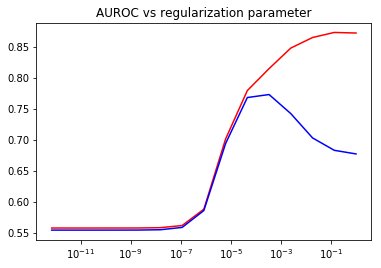

In [203]:
plt.title('AUROC vs regularization parameter')
plt.plot(np.array(reg), np.array(auc_train_32_scaled),'r')
plt.plot(np.array(reg), np.array(auc_val_32_scaled), 'b')
plt.xscale('log')
plt.show()

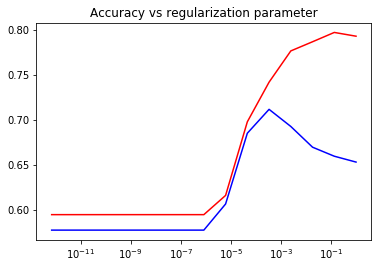

In [204]:
plt.title('Accuracy vs regularization parameter')
plt.plot(np.array(reg), np.array(acc_train_32_scaled),'r')
plt.plot(np.array(reg), np.array(acc_val_32_scaled), 'b')
plt.xscale('log')
plt.show()

In [205]:
print("Highest accuracy: ", np.max(acc_val_32_scaled))
print("Highest AUROC: ", np.max(auc_val_32_scaled))
print("The optimal regularization value is: ", reg[np.argmax(auc_val_32_scaled)])

Highest accuracy:  0.7115
Highest AUROC:  0.7726222495453263
The optimal regularization value is:  0.00033546262790251185


## Results
A logistic regression model using the full scale images performs better out-of-sample than a model using only the center of the image. However, neither model is close to the leaderboard scores on Kaggle (around 0.95 compared to 0.66-0.67 for our models). Below we perform some error analysis in order to get a better understanding of how we can potentially improve the performance.

First we look at how the performance of the model behaves when we increase the size of the training data:

In [169]:
acc_train_32_ea = []
acc_val_32_ea = []
auc_train_32_ea = []
auc_val_32_ea = []
cost_train_32 = []
cost_val_32 = []
c = reg[np.argmax(auc_val_32)]
for i in range(10,X.shape[0]+11, 100):
    print(i, end=' ')
    # fit a logistic regression using the 'optimal' regularization
    clf = LogisticRegression(solver='lbfgs', tol=1e-4, C=c).fit(X_32[:i], Y[:i])
    
    # evaluate accuracy and AUROC score on the training set
    y_pred_train = clf.predict(X_32[:i])
    proba_train = clf.predict_proba(X_32[:i])[:,1]
    acc_train_32_ea.append(1 - np.mean(np.abs(y_pred_train-Y[:i].T)))
    auc_train_32_ea.append(metrics.roc_auc_score(Y[:i], proba_train))
    
    # evaluate accuracy on the validation set
    y_pred_val = clf.predict(X_val_32)
    proba_val = clf.predict_proba(X_val_32)[:,1].reshape(-1,1)
    acc_val_32_ea.append(1 - np.mean(np.abs(y_pred_val-Y_val.T)))
    auc_val_32_ea.append(metrics.roc_auc_score(Y_val, proba_val))
    
    # evaluate the cost on train and validation set
    cost_train_32.append(-1/Y[:i].shape[0] * np.sum(Y[:i] * np.log(proba_train) + (1-Y[:i]) * (np.log(1-proba_train))))
    cost_val_32.append(-1/Y_val.shape[0] * np.sum(Y_val * np.log(proba_val) + (1-Y_val) * (np.log(1-proba_val))))

10 110 210 310 410 510 610 710 810 910 1010 1110 1210 1310 1410 1510 1610 1710 1810 1910 2010 2110 2210 2310 2410 2510 2610 2710 2810 2910 3010 3110 3210 3310 3410 3510 3610 3710 3810 3910 4010 4110 4210 4310 4410 4510 4610 4710 4810 4910 5010 5110 5210 5310 5410 5510 5610 5710 5810 5910 6010 

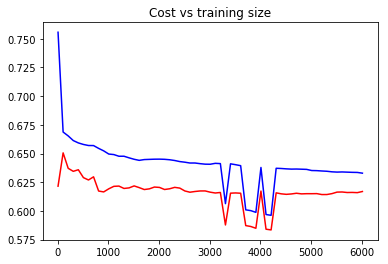

In [170]:
plt.title('Cost vs training size')
plt.plot(np.arange(10,X.shape[0]+11, 100), np.array(cost_train_32),'r')
plt.plot(np.arange(10,X.shape[0]+11, 100), np.array(cost_val_32), 'b')
plt.show()

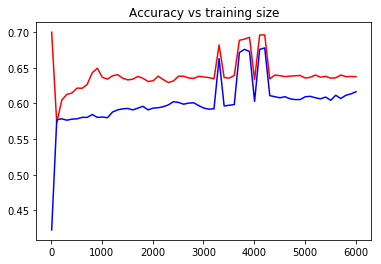

In [159]:
plt.title('Accuracy vs training size')
plt.plot(np.arange(10,X.shape[0]+11, 100), np.array(acc_train_32_ea),'r')
plt.plot(np.arange(10,X.shape[0]+11, 100), np.array(acc_val_32_ea), 'b')
plt.show()

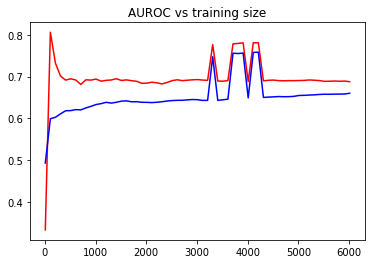

In [160]:
plt.title('AUROC vs training size')
plt.plot(np.arange(10,X.shape[0]+11, 100), np.array(auc_train_32_ea),'r')
plt.plot(np.arange(10,X.shape[0]+11, 100), np.array(auc_val_32_ea), 'b')
plt.show()